In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [2]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [3]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [4]:
path = r'D:\CIS-PD Study\Subjects' #Windows remote path
folder_path = r'D:\CIS-PD Study' #generic Windows repo path
dict_path = 'D:\CIS-PD Study\Data_dict'
scores_path = r'D:\CIS-PD Study\Scores' #remote repo
features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo

# if platform.system() == 'Windows':
#     if platform.release() == '10':
#         path = r'D:\CIS-PD Study\Subjects' #Windows remote path
#         folder_path = r'D:\CIS-PD Study' #generic Windows repo path
#         dict_path = 'D:\CIS-PD Study\Data_dict'
#         scores_path = r'D:\CIS-PD Study\Scores' #remote repo
#         features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
        
#     elif platform.release() == '7':
#         path = r'X:\CIS-PD Study\Subjects'
#         folder_path = r'X:\CIS-PD Study'
# #         dict_path = r'C:\Users\adai\Documents\Data_dict'
#         dict_path = r'X:\CIS-PD Study\Data_dict'
#         scores_path = r'X:\CIS-PD Study\Scores'
#         features_path = r'X:\CIS-PD Study\FeatureMatrix'
    
# else:
#     path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
#     folder_path = '/Volumes/RTO/CIS-PD Study/'
#     dict_path = '../Data_dict' # Mac local path
#     scores_path = '../Scores/' # Mac local path
#     features_path = '../FeatureMatrix' # Mac local path

# Load data

In [5]:
Data = pd.read_hdf(os.path.join(features_path,'Features_AllLocs_HP+LP_GyroLP.h5')) #bradykinesia
# Data = pd.read_hdf(os.path.join(features_path,'Features_AllLocs_BP.h5')) #tremor

#use only hand sensors
Data=Data.drop(['distal_lateral_shank__accel','distal_lateral_shank__gyro','flexor_digitorum__accel','medial_chest_accel','anterior_thigh__accel','anterior_thigh__gyro','sacrum_gyro','sacrum_accel'],axis=1)

print(Data.shape)
Data.head(2)

(47618, 9)


,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,dorsal_hand__accel,dorsal_hand__gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.007989930813309471, 0.00961279888662689, 0....","[2.6795366783469334, 1.6606829535680216, 4.133..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.007692838138012616, 0.009210303186171182, 0...","[3.268870793790155, 2.7118732998159794, 5.3276..."


#### This section reconciles the following - Load features, merge with metadata from raw datafiles, and resave as pkl file

In [6]:
namesuffix = 'HP+LP_GyroLP.pkl'
# namesuffix='BP.pkl'
# datafile = 'DataRaw_AllLocs_'+namesuffix
# featfile = 'Features_AllLocs_'+namesuffix
# output = 'MetaFeatures_'+namesuffix

# Data = pd.read_hdf(os.path.join(features_path,'Features_AllLocs_HP+LP_GyroLP.h5'))
# Data = Data.reset_index(drop=True)
# print(Data.shape)
# metadata = pickle.load(open(os.path.join(features_path,datafile),'rb'))
# metadata=metadata.reset_index(drop=True)
# metadata = metadata.iloc[:,:7]
# print(metadata.shape)
# #concatenates metadata
# Data=pd.concat((metadata,Data),axis=1)
# print(Data.shape)
# #save features pkl file
# f = open(os.path.join(features_path,output),'wb')
# pickle.dump(Data,f)
# f.close()

### Filter empty rows on  hand sensors only and unpack features and save

Filter on all locations 

In [7]:
#filter empty rows on all locations
for s in Data.columns.values[7:]:
    print('%s,discarded %d rows'%(s,sum(Data[s].apply(type) == float)))
    Data = Data[Data[s].apply(type) != float]

dorsal_hand__accel,discarded 6046 rows
dorsal_hand__gyro,discarded 0 rows


Filter on hand only

In [8]:
#filter empty rows (no features available) on hand sensors
print('discarded %d rows'%(len(Data[Data.dorsal_hand__accel.apply(type) == float])))
Data = Data[Data.dorsal_hand__accel.apply(type) != float]
print('discarded %d rows'%(len(Data[Data.dorsal_hand__gyro.apply(type) == float])))
Data = Data[Data.dorsal_hand__gyro.apply(type) != float]

discarded 0 rows
discarded 0 rows


In [9]:
Data.shape

(41572, 9)

In [10]:
Data.head()

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,dorsal_hand__accel,dorsal_hand__gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.007989930813309471, 0.00961279888662689, 0....","[2.6795366783469334, 1.6606829535680216, 4.133..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.007692838138012616, 0.009210303186171182, 0...","[3.268870793790155, 2.7118732998159794, 5.3276..."
2,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.006767186243379367, 0.009203679619930478, 0...","[2.625718268382984, 2.7725997168181644, 4.4002..."
3,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.007352144848440469, 0.01013037529611546, 0....","[2.4288628624248436, 0.9866435824157854, 4.258..."
4,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.007084818856755019, 0.00880787596180788, 0....","[3.159311859313414, 2.5882618611103747, 4.6503..."


In [11]:
#unpack features
colnames=['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
       'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
       'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
       'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
       'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
       'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']

# sensor_list = ['anterior_thigh_','dorsal_hand_','sacrum'] #sensors used
sensor_list = ['dorsal_hand_'] #hands only


colnames1=[i+'acc' for i in colnames]
colnames2=[i+'gyr' for i in colnames]
colnames=colnames1+colnames2

In [12]:
len(Data)

41572

In [13]:
Datafinal = pd.DataFrame()

for i in range(len(Data)):
    Datatemp=pd.DataFrame()
    for sensors in sensor_list:
        F1 = Data[sensors + '_accel'].iloc[i]
        F2 = Data[sensors + '_gyro'].iloc[i]
        F = pd.DataFrame(data=np.hstack((F1,F2)).reshape(-1,1).T,index=[i],columns=[i+'_'+sensors for i in colnames])
        Datatemp=pd.concat((Datatemp,F),axis=1)
    Datafinal = pd.concat((Datafinal,Datatemp),axis=0)

In [14]:
Datafinal.head(3)

,RMSXacc_dorsal_hand_,RMSYacc_dorsal_hand_,RMSZacc_dorsal_hand_,rangeXacc_dorsal_hand_,rangeYacc_dorsal_hand_,rangeZacc_dorsal_hand_,meanXacc_dorsal_hand_,meanYacc_dorsal_hand_,meanZacc_dorsal_hand_,varXacc_dorsal_hand_,...,PSD_stdgyr_dorsal_hand_,PSD_skewgyr_dorsal_hand_,PSD_kurgyr_dorsal_hand_,jerk_meangyr_dorsal_hand_,jerk_stdgyr_dorsal_hand_,jerk_skewgyr_dorsal_hand_,jerk_kurgyr_dorsal_hand_,Sen_Xgyr_dorsal_hand_,Sen_Ygyr_dorsal_hand_,Sen_Zgyr_dorsal_hand_
0,0.007990,0.009613,0.006777,0.599504,0.744752,0.483158,-0.002406,0.007534,0.003762,0.141336,...,385.995020,3.356436,13.163123,0.109848,7.518253,0.280635,-0.434568,0.364178,0.427683,0.352723
1,0.007693,0.009210,0.006636,0.535280,0.693556,0.445568,0.009642,-0.000565,0.003741,0.135758,...,605.040885,4.317019,17.782045,-0.186576,8.443760,0.374303,-0.674552,0.249201,0.253660,0.290202
2,0.006767,0.009204,0.005619,0.500241,0.693556,0.431977,0.004066,-0.013669,0.005962,0.119655,...,1524.671081,3.463916,10.844906,0.159265,7.091213,0.274833,-0.014505,0.273660,0.200925,0.192754


In [15]:
Datafinal=Datafinal.reset_index(drop=True)
# Datanew=Datanew.reset_index(drop=True)
Data=Data.reset_index(drop=True)

In [16]:
Data = pd.concat((Data.iloc[:,:7],Datafinal),axis=1)

In [17]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc_dorsal_hand_,RMSYacc_dorsal_hand_,RMSZacc_dorsal_hand_,...,PSD_stdgyr_dorsal_hand_,PSD_skewgyr_dorsal_hand_,PSD_kurgyr_dorsal_hand_,jerk_meangyr_dorsal_hand_,jerk_stdgyr_dorsal_hand_,jerk_skewgyr_dorsal_hand_,jerk_kurgyr_dorsal_hand_,Sen_Xgyr_dorsal_hand_,Sen_Ygyr_dorsal_hand_,Sen_Zgyr_dorsal_hand_
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007990,0.009613,0.006777,...,385.995020,3.356436,13.163123,0.109848,7.518253,0.280635,-0.434568,0.364178,0.427683,0.352723
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007693,0.009210,0.006636,...,605.040885,4.317019,17.782045,-0.186576,8.443760,0.374303,-0.674552,0.249201,0.253660,0.290202


In [18]:
Data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)

In [19]:
Datafinal.head(3)

,RMSXacc_dorsal_hand_,RMSYacc_dorsal_hand_,RMSZacc_dorsal_hand_,rangeXacc_dorsal_hand_,rangeYacc_dorsal_hand_,rangeZacc_dorsal_hand_,meanXacc_dorsal_hand_,meanYacc_dorsal_hand_,meanZacc_dorsal_hand_,varXacc_dorsal_hand_,...,PSD_stdgyr_dorsal_hand_,PSD_skewgyr_dorsal_hand_,PSD_kurgyr_dorsal_hand_,jerk_meangyr_dorsal_hand_,jerk_stdgyr_dorsal_hand_,jerk_skewgyr_dorsal_hand_,jerk_kurgyr_dorsal_hand_,Sen_Xgyr_dorsal_hand_,Sen_Ygyr_dorsal_hand_,Sen_Zgyr_dorsal_hand_
0,0.007990,0.009613,0.006777,0.599504,0.744752,0.483158,-0.002406,0.007534,0.003762,0.141336,...,385.995020,3.356436,13.163123,0.109848,7.518253,0.280635,-0.434568,0.364178,0.427683,0.352723
1,0.007693,0.009210,0.006636,0.535280,0.693556,0.445568,0.009642,-0.000565,0.003741,0.135758,...,605.040885,4.317019,17.782045,-0.186576,8.443760,0.374303,-0.674552,0.249201,0.253660,0.290202
2,0.006767,0.009204,0.005619,0.500241,0.693556,0.431977,0.004066,-0.013669,0.005962,0.119655,...,1524.671081,3.463916,10.844906,0.159265,7.091213,0.274833,-0.014505,0.273660,0.200925,0.192754


In [20]:
f = open(os.path.join(features_path,'UnpackedMetaFeat_' + namesuffix),'wb')
pickle.dump(Data,f)
f.close()

## Load unpacked features data

In [21]:
filename = 'UnpackedMetaFeat_HP+LP_GyroLP.pkl'
# filename = 'UnpackedMetaFeat_BP.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)
Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = Dataorig.reset_index(drop=True)
print(Dataorig.shape)

(41572, 81)
(41572, 81)


In [22]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc_dorsal_hand_,RMSYacc_dorsal_hand_,RMSZacc_dorsal_hand_,...,PSD_stdgyr_dorsal_hand_,PSD_skewgyr_dorsal_hand_,PSD_kurgyr_dorsal_hand_,jerk_meangyr_dorsal_hand_,jerk_stdgyr_dorsal_hand_,jerk_skewgyr_dorsal_hand_,jerk_kurgyr_dorsal_hand_,Sen_Xgyr_dorsal_hand_,Sen_Ygyr_dorsal_hand_,Sen_Zgyr_dorsal_hand_
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007990,0.009613,0.006777,...,385.995020,3.356436,13.163123,0.109848,7.518253,0.280635,-0.434568,0.364178,0.427683,0.352723
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.007693,0.009210,0.006636,...,605.040885,4.317019,17.782045,-0.186576,8.443760,0.374303,-0.674552,0.249201,0.253660,0.290202


In [23]:
#drop features 
Data=Data.drop(labels=['RMSXacc_dorsal_hand_','RMSYacc_dorsal_hand_','RMSZacc_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc_dorsal_hand_','meanYacc_dorsal_hand_','meanZacc_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc_dorsal_hand_','varYacc_dorsal_hand_','varZacc_dorsal_hand_'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr_dorsal_hand_','RMSYgyr_dorsal_hand_','RMSZgyr_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr_dorsal_hand_','meanYgyr_dorsal_hand_','meanZgyr_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr_dorsal_hand_','varYgyr_dorsal_hand_','varZgyr_dorsal_hand_'],axis=1) #range is strongly correlated with variance

In [24]:
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

In [25]:
Data.shape

(39849, 63)

In [26]:
Data.Visit.unique()

array(['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60',
       '2 Weeks: Time 90', '2 Weeks: Time 120', '2 Weeks: Time 150',
       '4 Weeks'], dtype=object)

In [27]:
Dataorig = Data.copy()

In [28]:
Dataorig['Bradykinesia'].unique()

array([ 1.,  0.,  2., nan,  3.])

In [29]:
Data['Bradykinesia'].unique()

array([ 1.,  0.,  2., nan,  3.])

In [30]:
visits = Data.Visit.unique()
visits[visits != '4 Weeks']

array(['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60',
       '2 Weeks: Time 90', '2 Weeks: Time 120', '2 Weeks: Time 150'],
      dtype=object)

In [31]:
Dataorig = Data.copy()
#remove nan symptoms
# symptom = 'Tremor'
symptom = 'Bradykinesia'
Data=Data[~Data[symptom].isnull()]

In [32]:
Data.shape
subjs=Data.Subject.unique()

## Global Models - Random Selection of Subjects

In [35]:
subjs=Data.Subject.unique()
tasks=Data.Task.unique()

#sample p subjects at random for train and test on remaining
ntrain = [4,8,16]
# ntrain = [2,4,8,12]
clf = RandomForestClassifier(n_estimators=50,random_state=2)

#remove nan rows for current symptom
Data=Data[~Data[symptom].isnull()]

results={}
for ng in ntrain:
    auc_all=[]; subj=[]; tasks_all=[];
    t1=time.time()
    for iteration in range(500):
        trainsubj = np.random.choice(subjs,size=ng,replace=False) #sample subjects at random
        
        # select random test subject out of remaining subjs not trained on
        testsubj = np.random.choice(np.setxor1d(subjs,trainsubj),size=1,replace=False)
        
        dtrain = Data[Data.Subject.isin(trainsubj)]
        dtest = Data[Data.Subject.isin(testsubj)]
        Xtr = dtrain.iloc[:,7:].as_matrix()
        ytr = (dtrain[symptom]>0).values.astype(int)
        Xte = dtest.iloc[:,7:].as_matrix()
        yte = (dtest[symptom]>0).values.astype(int)
        ytask = dtest[dtest[symptom]>0].Task
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        
        auc_all.append(auroc)
        subj.append(testsubj)
        tasks_all.append(ytask)
        
        if iteration%50==0:
            print('Subj=%s,Test=%s,Iter=%d, AUROC=%.3f'%(trainsubj,testsubj,iteration,auroc))

    results.update({ng:[auc_all,subj,tasks_all]}) #save auc for all runs for each group
    print('elapsed %.3f min'%((time.time()-t1)/60))

np.save('brady_subjsims_randomSubjs.npy',results)

Subj=[1051 1019 1004 1053],Test=[1047],Iter=0, AUROC=0.807
Subj=[1049 1055 1032 1038],Test=[1053],Iter=50, AUROC=0.681
Subj=[1053 1016 1029 1055],Test=[1046],Iter=100, AUROC=0.598
Subj=[1054 1047 1049 1004],Test=[1038],Iter=150, AUROC=0.694
Subj=[1047 1032 1051 1053],Test=[1056],Iter=200, AUROC=0.641
Subj=[1052 1051 1054 1038],Test=[1029],Iter=250, AUROC=0.555
Subj=[1032 1038 1024 1054],Test=[1055],Iter=300, AUROC=0.652
Subj=[1056 1024 1051 1053],Test=[1030],Iter=350, AUROC=0.666
Subj=[1019 1047 1018 1004],Test=[1030],Iter=400, AUROC=0.724
Subj=[1016 1051 1055 1046],Test=[1056],Iter=450, AUROC=0.742
elapsed 16.147 min
Subj=[1051 1046 1056 1032 1049 1052 1044 1030],Test=[1029],Iter=0, AUROC=0.572
Subj=[1018 1032 1054 1004 1052 1046 1016 1029],Test=[1049],Iter=50, AUROC=0.500
Subj=[1029 1052 1024 1044 1019 1018 1055 1004],Test=[1053],Iter=100, AUROC=0.724
Subj=[1018 1051 1038 1049 1047 1055 1030 1044],Test=[1046],Iter=150, AUROC=0.783
Subj=[1016 1029 1019 1049 1053 1055 1038 1046],Test=[

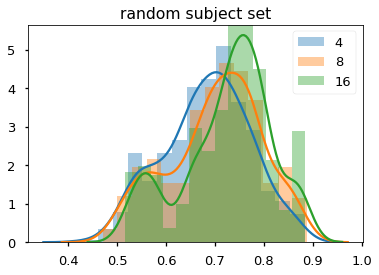

In [36]:
#load sim results
r = np.load('brady_subjsims_randomSubjs.npy')
r2=r.item()

for i in r2.keys():
    ax=sns.distplot(r2[i][0])
    ax.legend(r2.keys())
plt.title('random subject set')
plt.savefig('testRandomSubjectsResults.png',bbox_inches='tight')

In [ ]:
#load sim results
r = np.load('tremor_subjsims_randomVisits.npy')
r2=r.item()

for i in r2.keys():
    sc = np.array(r2[i][0])
    sc = sc[~np.isnan(sc)]
    ax=sns.distplot(sc)
    ax.legend(r2.keys())
plt.title('random visit set')
plt.savefig('tremor_testRandomVisitsResults.png',bbox_inches='tight')

In [178]:
# type(list(visits_day1[:6]))
type(testvisit)

list

## Global Models - Random Selection of Visits

In [33]:
visits_all=Data.Visit.unique()
visits_day1 = visits_all[visits_all != '4 Weeks']
tasks=Data.Task.unique()

#sample p visits at random for train and test on remaining
ntrain = [1,2,3,4,5,6]
clf = RandomForestClassifier(n_estimators=50,random_state=2)

#remove nan rows for current symptom
Data=Data[~Data[symptom].isnull()]

print(symptom)
results={}
for ng in ntrain:
    auc_all=[]; subj=[]; tasks_all=[];
    t1=time.time()
    for subs in subjs:
        data = Data[Data.Subject == subs]
        print(subs)
        for iteration in range(1):
    #         # select random test sessions out of all sessions, train on one remaining
    #         trainvisit = np.random.choice(visits_all,size=ng,replace=False) #sample subjects at random
    #         testvisit = np.random.choice(np.setxor1d(visits_all,trainvisit),size=1,replace=False)

            # select random test sessions out of all sessions, train on one remaining
    #         trainvisit = np.random.choice(visits_day1,size=ng,replace=False) #sample subjects at random

            trainvisit = list(visits_day1[0:ng])#cumulative sessions
#             trainvisit = [visits_day1[ng-1]] #individual sessions
            testvisit = ['4 Weeks']

            dtrain = data[data.Visit.isin(trainvisit)]
            dtest = data[data.Visit.isin(testvisit)]
            Xtr = dtrain.iloc[:,7:].as_matrix()
            ytr = (dtrain[symptom]>0).values.astype(int)
            Xte = dtest.iloc[:,7:].as_matrix()
            yte = (dtest[symptom]>0).values.astype(int)
            ytask = dtest[dtest[symptom]>0].Task
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            if np.size(Xte) == 0:
#                 auc_all.append(np.nan)
#                 subj.append(subs)
#                 tasks_all.append(testvisit)
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]

            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan

            auc_all.append(auroc)
            subj.append(subs)
            tasks_all.append(testvisit)

            if iteration%50==0:
                print('TrainVisit=%s,Test=%s,Iter=%d, AUROC=%.3f'%(trainvisit,testvisit,iteration,auroc))

        results.update({ng:[auc_all,subj,tasks_all]}) #save auc for all runs for each group
        print('elapsed %.3f min'%((time.time()-t1)/60))

np.save('brady_cumulative_subjsims_randomVisits.npy',results)

Bradykinesia
1004
TrainVisit=['2 Weeks: Time 0'],Test=['4 Weeks'],Iter=0, AUROC=0.355
elapsed 0.001 min
1016
TrainVisit=['2 Weeks: Time 0'],Test=['4 Weeks'],Iter=0, AUROC=0.998
elapsed 0.002 min
1018
TrainVisit=['2 Weeks: Time 0'],Test=['4 Weeks'],Iter=0, AUROC=0.798
elapsed 0.003 min
1019
TrainVisit=['2 Weeks: Time 0'],Test=['4 Weeks'],Iter=0, AUROC=0.785
elapsed 0.005 min
1024
TrainVisit=['2 Weeks: Time 0'],Test=['4 Weeks'],Iter=0, AUROC=0.553
elapsed 0.006 min
1029
TrainVisit=['2 Weeks: Time 0'],Test=['4 Weeks'],Iter=0, AUROC=0.780
elapsed 0.007 min
1030
TrainVisit=['2 Weeks: Time 0'],Test=['4 Weeks'],Iter=0, AUROC=0.710
elapsed 0.008 min
1032
TrainVisit=['2 Weeks: Time 0'],Test=['4 Weeks'],Iter=0, AUROC=0.722
elapsed 0.010 min
1038
TrainVisit=['2 Weeks: Time 0'],Test=['4 Weeks'],Iter=0, AUROC=0.545
elapsed 0.011 min
1044
TrainVisit=['2 Weeks: Time 0'],Test=['4 Weeks'],Iter=0, AUROC=0.815
elapsed 0.012 min
1046
TrainVisit=['2 Weeks: Time 0'],Test=['4 Weeks'],Iter=0, AUROC=0.866
elap

TrainVisit=['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60', '2 Weeks: Time 90', '2 Weeks: Time 120'],Test=['4 Weeks'],Iter=0, AUROC=0.457
elapsed 0.044 min
1044
TrainVisit=['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60', '2 Weeks: Time 90', '2 Weeks: Time 120'],Test=['4 Weeks'],Iter=0, AUROC=0.811
elapsed 0.048 min
1046
TrainVisit=['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60', '2 Weeks: Time 90', '2 Weeks: Time 120'],Test=['4 Weeks'],Iter=0, AUROC=0.854
elapsed 0.053 min
1047
elapsed 0.054 min
1049
TrainVisit=['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60', '2 Weeks: Time 90', '2 Weeks: Time 120'],Test=['4 Weeks'],Iter=0, AUROC=0.407
elapsed 0.059 min
1051
TrainVisit=['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60', '2 Weeks: Time 90', '2 Weeks: Time 120'],Test=['4 Weeks'],Iter=0, AUROC=0.720
elapsed 0.063 min
1052
elapsed 0.063 min
1053
elapsed 0.063 min
1054
elapsed 0.063 min
1055
elapsed 0.063 min
1056
elapsed 0.063 min
1004
Tr

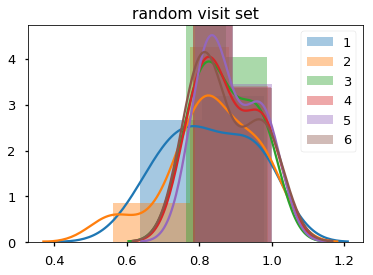

In [42]:
#load sim results
r = np.load('tremor_cumulative_subjsims_randomVisits.npy')
r2=r.item()

for i in r2.keys():
    sc = np.array(r2[i][0])
    sc = sc[~np.isnan(sc)]
    ax=sns.distplot(sc)
    ax.legend(r2.keys())
plt.title('random visit set')
# plt.savefig('tremor_cumulative_testRandomVisitsResults.png',bbox_inches='tight')

In [41]:
df

,1,2,3,4,5,6
1004,0.355226,0.666037,0.755906,0.790257,0.776177,0.776885
1016,0.997529,0.997838,0.995212,0.993513,0.983318,0.990269
1018,0.797681,0.733527,0.714106,0.714461,0.749308,0.720386
1019,0.785189,0.828957,0.908403,0.930322,0.950735,0.937430
1024,0.552799,0.560632,0.723803,0.714785,0.690570,0.708950
1029,0.780124,0.693584,0.695320,0.688543,0.695252,0.672093
1030,0.710307,0.742325,0.790014,0.805720,0.844683,0.836206
1032,0.722150,0.646480,0.623628,0.705437,0.680406,0.673039
1038,0.545378,0.512181,0.478804,0.494663,0.457034,0.445034
1044,0.815158,0.826297,0.817733,0.831207,0.811325,0.823901


In [45]:
df

,1,2,3,4,5,6
1004,0.718819,0.784498,0.793786,0.785383,0.789142,0.803184
1016,NaN,NaN,NaN,NaN,NaN,NaN
1018,0.955495,0.971016,0.987363,0.997253,0.999863,1.000000
1019,0.638312,0.562338,0.762554,0.797186,0.882684,0.788961
1024,0.701730,0.716945,0.793984,0.782051,0.827078,0.784407
1029,0.850194,0.816553,0.856708,0.834188,0.815445,0.806915
1030,0.959656,0.901455,0.940079,0.957275,0.965476,0.975132
1032,0.979116,0.988956,0.970683,0.966667,0.966265,0.964056
1038,0.768806,0.848024,0.878644,0.871717,0.853931,0.864598
1044,0.932787,0.959563,0.962022,0.975683,0.969399,0.968306


In [44]:
# df = pd.DataFrame()
# for n in r2.keys():
#     sub = np.array(r2[n][1])
#     auroc1 = pd.DataFrame(data=np.array(r2[n][0]),index=sub,columns=[int(n)])
#     df = pd.concat([df,auroc1],axis=1)

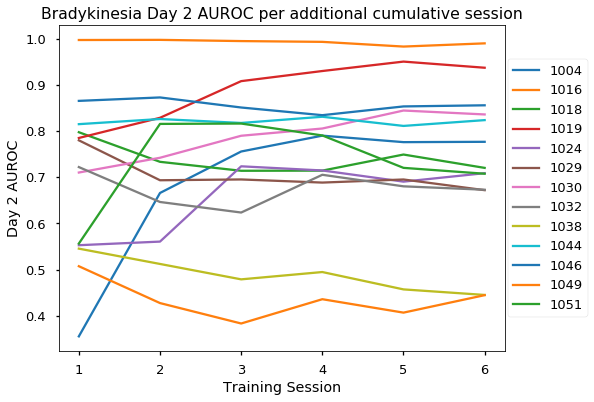

In [36]:
#load sim results
r = np.load('brady_cumulative_subjsims_randomVisits.npy')
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    sub = np.array(r2[n][1])
    auroc1 = pd.DataFrame(data=np.array(r2[n][0]),index=sub,columns=[int(n)])
    df = pd.concat([df,auroc1],axis=1)

df.T.plot(figsize=(8,6))
plt.legend(loc='center right',bbox_to_anchor=(1.2,0.5));
plt.title('Bradykinesia Day 2 AUROC per additional cumulative session');
plt.xlabel('Training Session');
plt.ylabel('Day 2 AUROC');
plt.savefig('brady_cumulative_auroc_perSession.png',bbox_inches='tight')

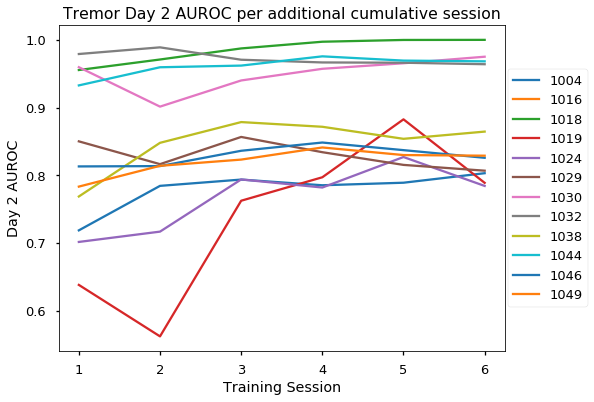

In [46]:
#load sim results
r = np.load('tremor_cumulative_subjsims_randomVisits.npy')
r2=r.item()

df = pd.DataFrame()
for n in r2.keys():
    sub = np.array(r2[n][1])
    auroc1 = pd.DataFrame(data=np.array(r2[n][0]),index=sub,columns=[int(n)])
    df = pd.concat([df,auroc1],axis=1)

df.T.plot(figsize=(8,6))
plt.legend(loc='center right',bbox_to_anchor=(1.2,0.5));
plt.title('Tremor Day 2 AUROC per additional cumulative session');
plt.xlabel('Training Session');
plt.ylabel('Day 2 AUROC');
plt.savefig('tremor_cumulative_auroc_perSession.png',bbox_inches='tight')

In [ ]:
# for sub in Data.Task.unique():
#     plt.figure(figsize=(8,6));
#     for n in r2.keys():
#         all_results = np.expand_dims(r2[n][0],1);
# #         subject_list = np.array(r2[n][1]);
#         task_list = r2[n][2];
        
#         inds = [i for i, s in enumerate(task_list) if s == sub]
        
#         d = all_results[inds]
        
#         ax=sns.distplot(d);
#         ax.legend(r2.keys());
#     plt.title('Task %s results'%sub);
#     plt.savefig('Task%s.png'%sub, bbox_inches='tight');

In [ ]:
# for i in results.keys():
#     ax=sns.distplot(results[i])
#     ax.legend(results.keys())
# plt.title('random test features set')
# plt.savefig('testRandomResults.png',bbox_inches='tight')

## Personal Models - Train on One Session Test on Rest

In [ ]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_1 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
print('Training on 1 session, testing on remainder...')
ds = Data.loc[Data.Visit != '4 Weeks']
ds2 = Data.loc[Data.Visit == '4 Weeks'] #(Day 2)

#train/test on Day 1
indp = (ds[symptom]>0).values
y = indp.astype(int) #target 
X = ds.iloc[:,7:].as_matrix()
#     X = StandardScaler().fit_transform(X) #standardize input data

models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = le.fit_transform(ds.Visit)
# if len(np.unique(groups))<2:
#     continue

#train/test on day 1 (LOin)
res,res_group = LOSOCV(ds,X,y,groups,models,LOin=1)
#     res.index = res.index+s
res_all=pd.concat((res_all,res))
res_visit_all.append(res_group)
# day1_1 = res_all.auroc #mean auc per subject across 
day1_1 = res_group['Random Forest']['auroc']

#test on day 2    
if ds2.empty is False:
    print('Testing on day 2')
    clf = models[0][0]
    X2 = ds2.iloc[:,7:].as_matrix()
    yte = (ds2[symptom]>0).values.astype(int) 
    yscore = clf.predict_proba(X2)
    yscore = yscore[:,1]
    if len(np.unique(yte))>1:
        auroc = roc_auc_score(yte,yscore)
    else:
        print('only 1 class in test data - cannot compute roc curve')
        auroc = np.nan
    auroc2_1.append(auroc) #auc from each subject when tested on day 2

plt.bar(range(7),list(np.squeeze([day1_1 + auroc2_1])));
plt.title('Training on 1 session from Day 1');
plt.xlabel('Visit Left In');
plt.ylabel('AUROC');
plt.savefig('LOVI-Global.png',bbox_inches='tight')

    


## Personal Models - Train on 5 visits, test on remaining

In [ ]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_5 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
print('Training on 5 visits...')
ds = Data.loc[Data.Visit != '4 Weeks']
ds2 = Data.loc[Data.Visit == '4 Weeks'] #(Day 2)

#train/test on Day 1
indp = (ds[symptom]>0).values
y = indp.astype(int) #target 
X = ds.iloc[:,7:].as_matrix()
#     X = StandardScaler().fit_transform(X) #standardize input data

models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = le.fit_transform(ds.Visit)
# if len(np.unique(groups))<2:
#     continue

#train/test on day 1 (LOin)
res,res_group = LOSOCV(ds,X,y,groups,models,LOin=0)
# res.index = res.index+s
res_all=pd.concat((res_all,res))
res_visit_all.append(res_group)
day1_5 = res_group['Random Forest']['auroc'] #mean auc per subject across 

#test on day 2    
if ds2.empty is False:
    print('Testing on day 2')
    clf = models[0][0]
    X2 = ds2.iloc[:,7:].as_matrix()
    yte = (ds2[symptom]>0).values.astype(int) 
    yscore = clf.predict_proba(X2)
    yscore = yscore[:,1]
    if len(np.unique(yte))>1:
        auroc = roc_auc_score(yte,yscore)
    else:
        print('only 1 class in test data - cannot compute roc curve')
        auroc = np.nan
    auroc2_5.append(auroc) #auc from each subject when tested on day 2

plt.bar(range(7),list(np.squeeze([day1_5 + auroc2_1])));
plt.xlabel('Visit Left Out');
plt.ylabel('AUROC');
plt.title('Train on 5 Sessions from Day 1')
plt.savefig('LOVO-Global.png',bbox_inches='tight')

In [ ]:
def LPGOCV(X,y,groups,models,ng):

    subj = LeavePGroupsOut(n_groups=ng) 
    results = pd.DataFrame(data=None,columns=['model','f1','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres

# Subgroup of tasks (4)

In [ ]:
filename = 'Features_AllLocs_HP+LP_GyroLP.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)

In [ ]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

Dataorig = Data.copy()
#remove nan symptoms
symptom = 'Bradykinesia'
Data=Data[~Data[symptom].isnull()]

In [ ]:
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB,taskC,taskD]